# Data Science for Fraud Detection
<img align="right" src='https://bashny.net/uploads/images/00/00/44/2016/09/19/acae85e767.jpg' width=35%>

### Enterprise Advanced Analytics: IT Systems & Risk Management

**The aim is to explore, visualize and pre-process fraud related financial transaction data, then experiment with a (simple) machine learning model to learn and predict fraudulent transaction. Evaluate performance of the new model vs. existing practice.**


By: 


顾 瞻 GU Zhan (Sam) [LinkedIn](https://sg.linkedin.com/in/zhan-gu-27a82823)


[SamIsITspecialist@gmail.com](SamIsITspecialist@gmail.com)


June 2017


---

The CSV tabular data for analysis has **6 millon plus** financial transactions, containing **11 fields**. Here is some sample data:

|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:
|1|PAYMENT|9839.64|C1231006815|170136.00|160296.36|M1979787155|0.0|0.00|0|0
|1|PAYMENT|1864.28|C1666544295|21249.00|19384.72|M2044282225|0.0|0.00|0|0
|1|TRANSFER|181.00|C1305486145|181.00|0.00|C553264065|0.0|0.00|1|0
|1|CASH_OUT|181.00|C840083671|181.00|0.00|C38997010|21182.0|0.00|1|0
|1|PAYMENT|11668.14|C2048537720|41554.00|29885.86|M1230701703|0.0|0.00|0|0
|1|PAYMENT|7817.71|C90045638|53860.00|46042.29|M573487274|0.0|0.00|0|0
|1|PAYMENT|7107.77|C154988899|183195.00|176087.23|M408069119|0.0|0.00|0|0
|1|PAYMENT|7861.64|C1912850431|176087.23|168225.59|M633326333|0.0|0.00|0|0
|1|PAYMENT|4024.36|C1265012928|2671.00|0.00|M1176932104|0.0|0.00|0|0
|1|DEBIT|5337.77|C712410124|41720.00|36382.23|C195600860|41898.0|40348.79|0|0

The tagged fields: 
* **isFraud** indicates actual fraudulent transactiona. 
* **isFlaggedFraud** indicates suspicious fraudulent transactiona detected by current IT system, risk management process.


### Import libraries

In [1]:
# from __future__ import unicode_literals
# from __future__ import division
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import statsmodels
import seaborn as sns
sns.set_style("dark")
from scipy.stats import skew, boxcox
from sklearn import preprocessing
from sklearn import svm 
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve,auc
from sklearn.metrics import roc_auc_score,roc_curve,recall_score,classification_report 
import warnings
warnings.filterwarnings("ignore")

/home/user/env_py3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Utilities-related functions
def now():
    tmp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return tmp

def my_file_read(file):
    df = pd.read_csv(file)
    print("{}: {} has {} observations and {} columns".format(now(), file, df.shape[0], df.shape[1]))
    print('')
    print("{}: Column name checking::: {}".format(now(), df.columns.tolist()))
    return df

# Self-defined function to read dataframe and find the missing data on the columns and # of missing
def checking_na(df):
    try:
        if (isinstance(df, pd.DataFrame)):
            df_na_bool = pd.concat([df.isnull().any(), df.isnull().sum(), (df.isnull().sum()/df.shape[0])*100],
                                   axis=1, keys=['df_bool', 'df_amt', 'missing_ratio_percent'])
            df_na_bool = df_na_bool.loc[df_na_bool['df_bool'] == True]
            return df_na_bool
        else:
            print("{}: The input is not panda DataFrame".format(now()))

    except (UnboundLocalError, RuntimeError):
        print("{}: Something is wrong".format(now()))

### Ingest financial transaction input data:

In [3]:
raw_data = my_file_read("PS_20174392719_1491204439457_log.csv")

2017-06-04 00:21:20: PS_20174392719_1491204439457_log.csv has 6362620 observations and 11 columns

2017-06-04 00:21:20: Column name checking::: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


### Quickly look at the dataset sample and other properties:

In [4]:
raw_data.head(10)
# raw_data.info()
# print(checking_na(raw_data))

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [5]:
raw_data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


## 1. Exploratory Data Analysis
Let's explore to better understand the data. Rhere are five transaction types as shown below.

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


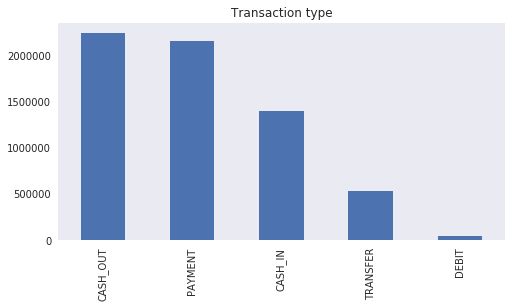

In [6]:
print(raw_data.type.value_counts())

f, ax = plt.subplots(1, 1, figsize=(8, 4))
raw_data.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8, 4))
plt.show()

There are two flags:  **isFraud** is the indicator which indicates the actual fraud transactions whereas **isFlaggedFraud** is what the system prevents the transaction due to internal thresholds being triggered.


Let's look at:

### Transactions which are the actual fraud:

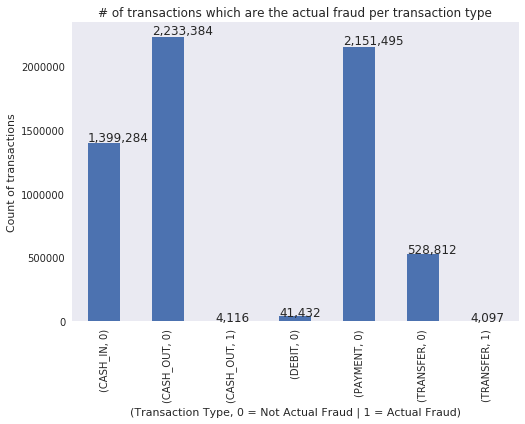

In [7]:
# isFraud
ax = raw_data.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("# of transactions which are the actual fraud per transaction type")
ax.set_xlabel("(Transaction Type, 0 = Not Actual Fraud | 1 = Actual Fraud)")
ax.set_ylabel("Count of transactions")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

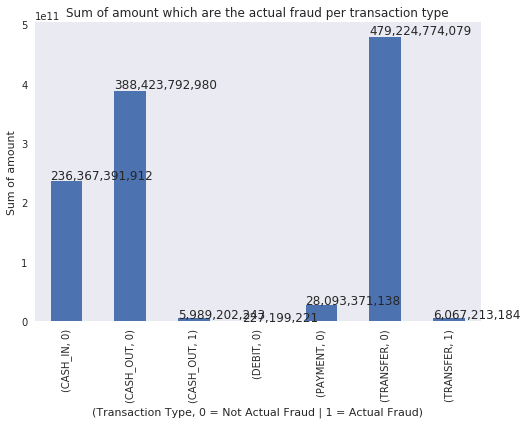

In [8]:
# isFraud - sum of amount/loss
ax = raw_data.groupby(['type', 'isFraud'])['amount'].sum().plot(kind='bar')
# ax = raw_data.groupby(['type', 'isFraud'])['amount'].mean().plot(kind='bar')
ax.set_title("Sum of amount which are the actual fraud per transaction type")
ax.set_xlabel("(Transaction Type, 0 = Not Actual Fraud | 1 = Actual Fraud)")
ax.set_ylabel("Sum of amount")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

### Transactions which are flagged by existing IT system:

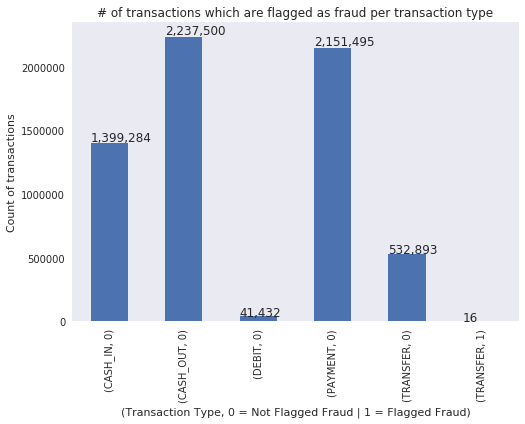

In [9]:
# isFlaggedFraud
ax = raw_data.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_title("# of transactions which are flagged as fraud per transaction type")
ax.set_xlabel("(Transaction Type, 0 = Not Flagged Fraud | 1 = Flagged Fraud)")
ax.set_ylabel("Count of transactions")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

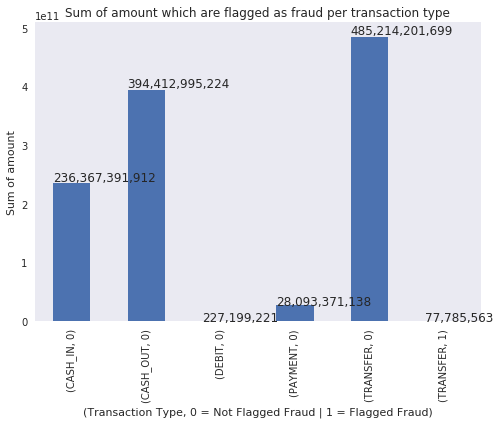

In [10]:
# isFlaggedFraud - sum of amount/loss
ax = raw_data.groupby(['type', 'isFlaggedFraud'])['amount'].sum().plot(kind='bar')
# ax = raw_data.groupby(['type', 'isFlaggedFraud'])['amount'].mean().plot(kind='bar')
ax.set_title("Sum of amount which are flagged as fraud per transaction type")
ax.set_xlabel("(Transaction Type, 0 = Not Flagged Fraud | 1 = Flagged Fraud)")
ax.set_ylabel("Sum of amount")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

### Loss Amount: Actual Fraud vs. IT System Flagged Farud

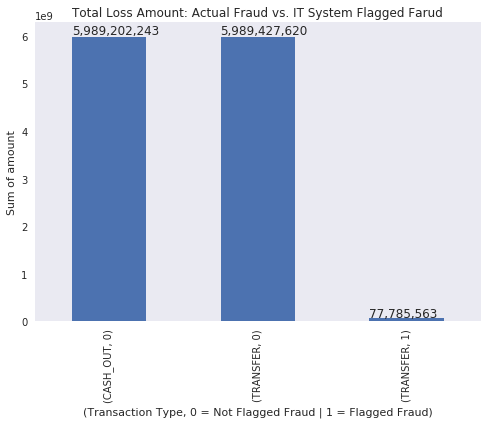

In [11]:
# isFlaggedFraud - sum of amount/loss
# tmp_data = raw_data[raw_data['isFraud'] ==1]
ax = raw_data[raw_data['isFraud'] ==1].groupby(['type', 'isFlaggedFraud'])['amount'].sum().plot(kind='bar')
# ax = raw_data[raw_data['isFraud'] ==1].groupby(['type', 'isFlaggedFraud'])['amount'].mean().plot(kind='bar')
# ax = raw_data.groupby(['type', 'isFlaggedFraud'])['amount'].mean().plot(kind='bar')
ax.set_title("Total Loss Amount: Actual Fraud vs. IT System Flagged Farud")
ax.set_xlabel("(Transaction Type, 0 = Not Flagged Fraud | 1 = Flagged Fraud)")
ax.set_ylabel("Sum of amount")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

### <font color='red'>Insights:</font>
* The current IT system can flag only **16** transfer transactions as fraud (out of **4,097 Transaction** + **4,116 Cash_Out** actual fraud). 
* Ratio of detected fraud amount over total fraud amount is **77,785,563 / (5,989,202,242 + 5,989427620 + 77,785,563) = 0.64518 %**

Let's look at those records and compare with the records which the system cannot catch them, focusing on: (1) Transfer transaction type (2) is actual fraud

Total Number of transactions type TRANSFER : 532909
Total Number of transactions Actual  Fraud : 4097
Total Number of transactions Flagged Fraud : 16


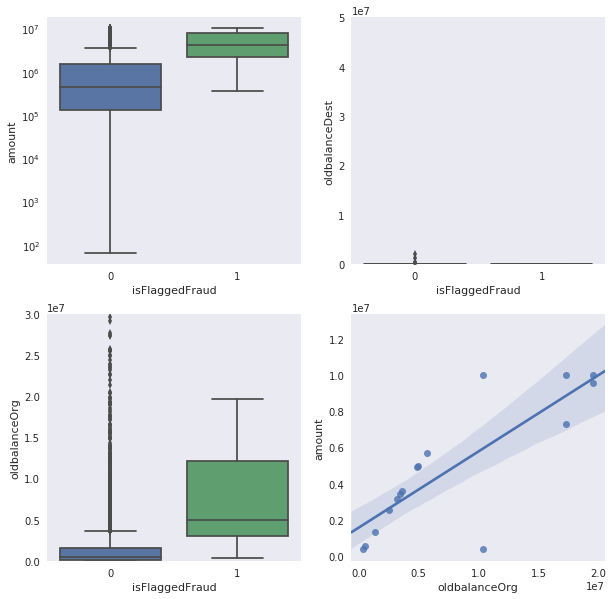

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
tmp = raw_data.loc[(raw_data.type == 'TRANSFER'), :]
print('Total Number of transactions type TRANSFER : %d' % len(tmp))
tmp = tmp.loc[(tmp.isFraud ==1)]
print('Total Number of transactions Actual  Fraud : %d' % len(tmp))
print('Total Number of transactions Flagged Fraud : %d' % len(tmp.loc[(tmp.isFlaggedFraud ==1), :]))

a = sns.boxplot(x = 'isFlaggedFraud', y = 'amount', data = tmp, ax=axs[0][0])
axs[0][0].set_yscale('log')
b = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceDest', data = tmp, ax=axs[0][1])
axs[0][1].set(ylim=(0, 0.5e8))
c = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceOrg', data=tmp, ax=axs[1][0])
axs[1][0].set(ylim=(0, 3e7))
d = sns.regplot(x = 'oldbalanceOrg', y = 'amount', data=tmp.loc[(tmp.isFlaggedFraud ==1), :], ax=axs[1][1])
plt.show()

## 2. Modeling & Data Pre-processing
In this section, we will focus only **Transfer** and **Cash Out** transaction types, as they have been identified having actual fraud.

In [13]:
from statsmodels.tools import categorical

# 1. Keep only interested transaction type ('TRANSFER', 'CASH_OUT')
# 2. Drop some columns
# 3. Convert categorical variables to numeric variable
tmp = raw_data.loc[(raw_data['type'].isin(['TRANSFER', 'CASH_OUT'])),:]
tmp.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)
tmp = tmp.reset_index(drop=True)
a = np.array(tmp['type'])
b = categorical(a, drop=True)
tmp['type_num'] = b.argmax(1)

tmp.head(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_num
0,TRANSFER,181.00,181.00,0.0,0.0,0.00,1,1
1,CASH_OUT,181.00,181.00,0.0,21182.0,0.00,1,0
2,CASH_OUT,229133.94,15325.00,0.0,5083.0,51513.44,0,0
3,TRANSFER,215310.30,705.00,0.0,22425.0,0.00,0,1
4,TRANSFER,311685.89,10835.00,0.0,6267.0,2719172.89,0,1
5,CASH_OUT,110414.71,26845.41,0.0,288800.0,2415.16,0,0
6,CASH_OUT,56953.90,1942.02,0.0,70253.0,64106.18,0,0
7,CASH_OUT,5346.89,0.00,0.0,652637.0,6453430.91,0,0
8,CASH_OUT,23261.30,20411.53,0.0,25742.0,0.00,0,0
9,TRANSFER,62610.80,79114.00,16503.2,517.0,8383.29,0,1


### Let's see the paired data field's correlation:

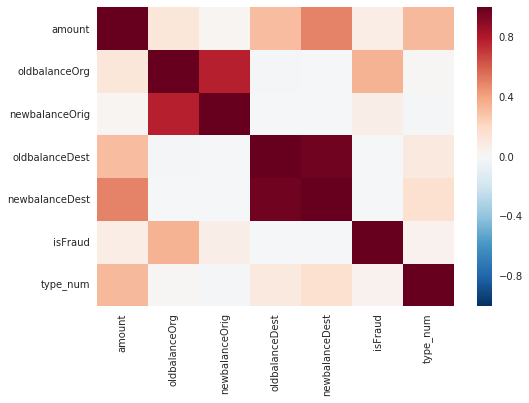

In [14]:
def correlation_plot(df):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation = "nearest", cmap = cmap)
    ax1.grid(True)
    plt.title("Correlation Heatmap")
    labels = df.columns.tolist()
    ax1.set_xticklabels(labels, fontsize=13, rotation=45)
    ax1.set_yticklabels(labels, fontsize=13)
    fig.colorbar(cax)
    plt.show()
    
# correlation_plot(tmp)

# Alternatively, we can use quick seaborn
# plot the heatmap
sns.heatmap(tmp.corr())

### Below we can see that those values in original numeric fields are very skew. We then conduct re-scale data transformation using two methods: Square-Root and Box-Cox:

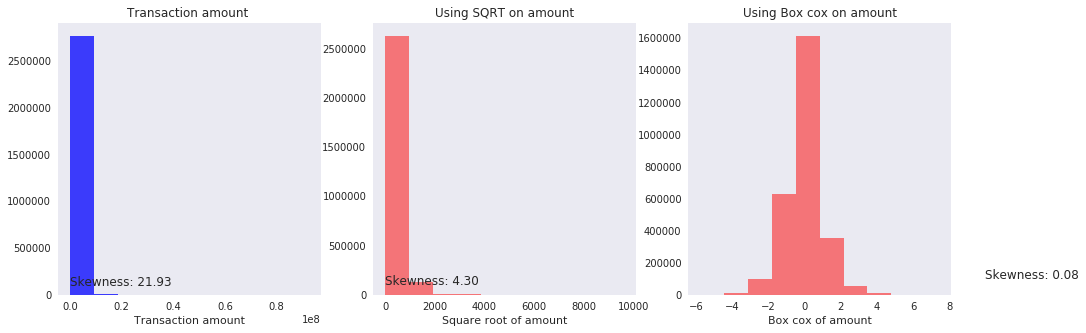

In [15]:
tmp['amount_boxcox'] = preprocessing.scale(boxcox(tmp['amount']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['amount'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("Transaction amount") 
plt.title("Transaction amount ") 
plt.text(10,100000,"Skewness: {0:.2f}".format(skew(tmp['amount'])))

figure.add_subplot(132)
plt.hist(np.sqrt(tmp['amount']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of amount")
plt.title("Using SQRT on amount")
plt.text(10, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['amount']))))

figure.add_subplot(133)
plt.hist(tmp['amount_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of amount")
plt.title("Using Box cox on amount")
plt.text(10, 100000, "Skewness: {0:.2f}".format(skew(tmp['amount_boxcox'])))

plt.show()

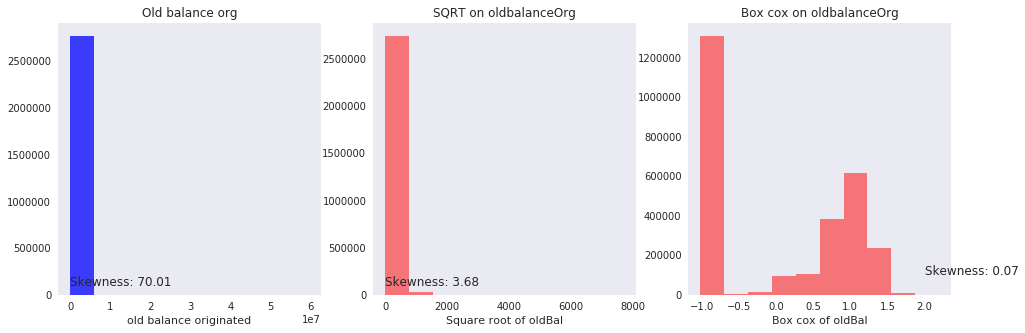

In [16]:
tmp['oldbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['oldbalanceOrg']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['oldbalanceOrg'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("old balance originated") 
plt.title("Old balance org") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['oldbalanceOrg'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['oldbalanceOrg']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of oldBal")
plt.title("SQRT on oldbalanceOrg")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['oldbalanceOrg']))))

figure.add_subplot(133)
plt.hist(tmp['oldbalanceOrg_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of oldBal")
plt.title("Box cox on oldbalanceOrg")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['oldbalanceOrg_boxcox'])))

plt.show()


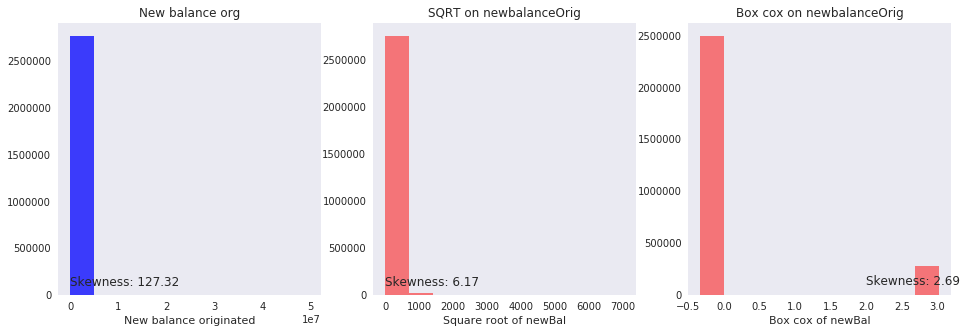

In [17]:
tmp['newbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['newbalanceOrig']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['newbalanceOrig'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("New balance originated") 
plt.title("New balance org") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['newbalanceOrig'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['newbalanceOrig']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of newBal")
plt.title("SQRT on newbalanceOrig")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['newbalanceOrig']))))

figure.add_subplot(133)
plt.hist(tmp['newbalanceOrg_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of newBal")
plt.title("Box cox on newbalanceOrig")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['newbalanceOrg_boxcox'])))

plt.show()

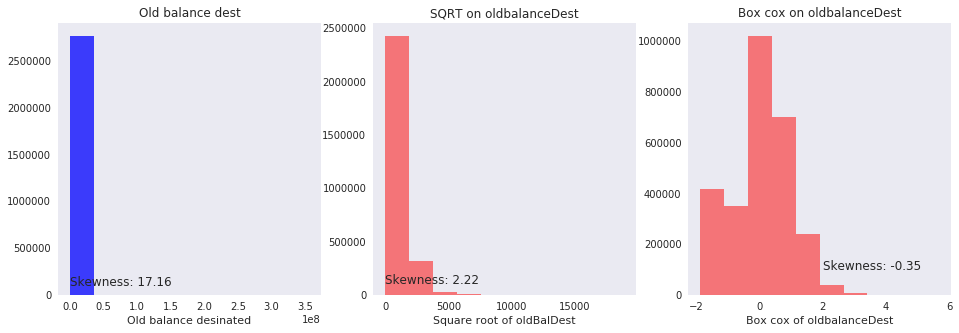

In [18]:
tmp['oldbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['oldbalanceDest']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['oldbalanceDest'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("Old balance desinated") 
plt.title("Old balance dest") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['oldbalanceDest'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['oldbalanceDest']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of oldBalDest")
plt.title("SQRT on oldbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['oldbalanceDest']))))

figure.add_subplot(133)
plt.hist(tmp['oldbalanceDest_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of oldbalanceDest")
plt.title("Box cox on oldbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['oldbalanceDest_boxcox'])))

plt.show()

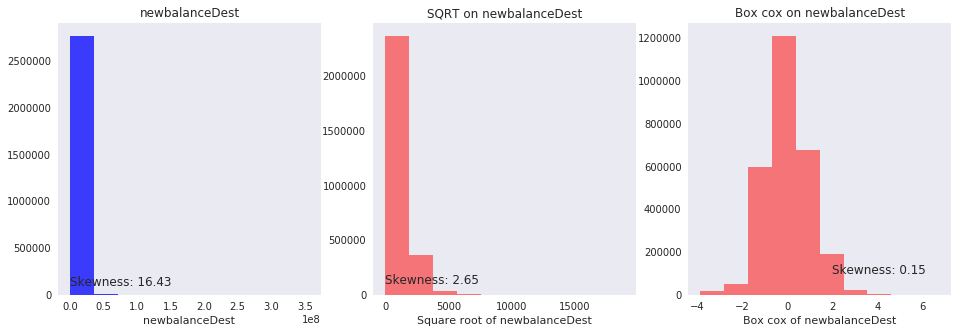

In [19]:
tmp['newbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['newbalanceDest']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['newbalanceDest'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("newbalanceDest") 
plt.title("newbalanceDest") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['newbalanceDest'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['newbalanceDest']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of newbalanceDest")
plt.title("SQRT on newbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['newbalanceDest']))))

figure.add_subplot(133)
plt.hist(tmp['newbalanceDest_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of newbalanceDest")
plt.title("Box cox on newbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['newbalanceDest_boxcox'])))

plt.show()

### Visualize transaction type, actual fraud count:

Total unber of transactions: 2770409


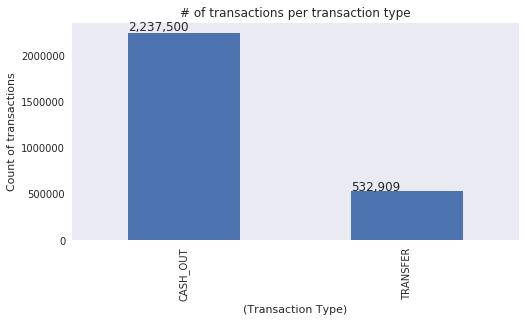

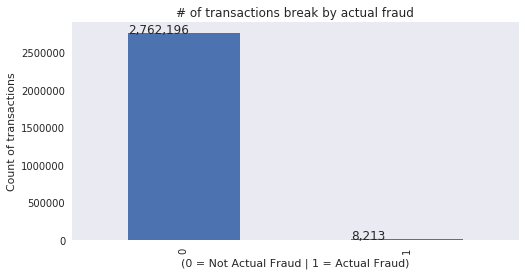

In [20]:
print('Total unber of transactions: %d' % len(tmp))

# print(pd.value_counts(tmp['isFraud']) / len(tmp))
# 0.99703545577566344897089202352432

ax = tmp.type.value_counts().plot(kind='bar', title="Transaction type", figsize=(8, 4))
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))
ax.set_title("# of transactions per transaction type")
ax.set_xlabel("(Transaction Type)")
ax.set_ylabel("Count of transactions")
plt.show()

ax = pd.value_counts(tmp['isFraud'], sort = True).sort_index().plot(kind='bar', title="Fraud transaction count", figsize=(8, 4))
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))   
ax.set_title("# of transactions break by actual fraud")
ax.set_xlabel("(0 = Not Actual Fraud | 1 = Actual Fraud)")
ax.set_ylabel("Count of transactions")
plt.show()


In [21]:
print("Fraud ratio of \'Transfer & Cash_Out\' transactions: {0:.4f} %".format((len(tmp[tmp.isFraud == 1])/len(tmp)) * 100))

Fraud ratio of 'Transfer & Cash_Out' transactions: 0.2965 %


### Conduct re-sampling due to imbalanced data

We filtered unrelated transaction type out and keep only relevant transaction types. The fraud occurrence is less than 0.3%. This is very imbalance data.


Heavily imbalaned data is to bias machine learning. We need use traditional way to process data, i.e. under-sampling method, over-sampling, SMOTE, etc. Here we under-sample the dataset by creating a 60-40 ratio of randomly selecting '1.5x' amount of sample from majority (Not Fraud) class, with 'x' being the total number of records with the minority (Fraud) class.

In [22]:
tmp.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'amount', 'type'], axis=1, inplace=True)

X = tmp.ix[:, tmp.columns != 'isFraud']
y = tmp.ix[:, tmp.columns == 'isFraud']

In [23]:
# Number of data points in the minority class
number_records_fraud = len(tmp[tmp.isFraud == 1])
fraud_indices = tmp[tmp.isFraud == 1].index.values

# Picking the indices of the normal classes
normal_indices = tmp[tmp.isFraud == 0].index

number_records_non_fraud = int(number_records_fraud * 1.5)

# Out of the indices we picked, randomly select "x" number (x - same as total fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_non_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])
under_sample_data = tmp.iloc[under_sample_indices, :]

X_undersample = under_sample_data.ix[:, under_sample_data.columns != 'isFraud']
y_undersample = under_sample_data.ix[:, under_sample_data.columns == 'isFraud']

# Showing ratio
print("Percentage of normal transactions : ", len(under_sample_data[under_sample_data.isFraud == 0])/len(under_sample_data))
print("Percentage of fraud  transactions : ", len(under_sample_data[under_sample_data.isFraud == 1])/len(under_sample_data))
print("Re-sampled number of transactions : ", len(under_sample_data))

Percentage of normal transactions :  0.5999902591077343
Percentage of fraud  transactions :  0.4000097408922657
Re-sampled number of transactions :  20532


## 3. Train Machine Learning Model

For demo purpose, we use a simple linear logistic regression classification model. More options include: random forest, gradient boosting, svm, bayesian net, simple or deep neural nets.

In [24]:
# Split dataset to taining set and test set randomly

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# print("Number transactions train dataset: ", format(len(X_train),',d'))
# print("Number transactions test dataset: ", format(len(X_test), ',d'))
# print("Total number of transactions: ", format(len(X_train)+len(X_test), ',d'))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions train dataset: ", format(len(X_train_undersample),',d'))
print("Number transactions test  dataset: ", format(len(X_test_undersample),',d'))
print("Total number of transactions     : ", format(len(X_train_undersample)+len(X_test_undersample),',d'))


Number transactions train dataset:  14,372
Number transactions test  dataset:  6,160
Total number of transactions     :  20,532


In [25]:
# inputs (predictors)
X_train_undersample.tail()

,type_num,amount_boxcox,oldbalanceOrg_boxcox,newbalanceOrg_boxcox,oldbalanceDest_boxcox,newbalanceDest_boxcox
2087230,0,-0.864005,-1.019720,-0.331128,-0.539393,-1.094802
795461,1,0.839331,-1.019720,-0.331128,0.030651,-0.021810
2324084,0,0.405879,-1.019720,-0.331128,1.528904,1.710381
1382240,0,-1.113565,0.932839,-0.331128,-0.812618,-1.440073
1398669,0,0.596818,1.378444,-0.331128,-0.932416,-0.625755


In [26]:
# target (to be predicted)
y_train_undersample.tail()

,isFraud
2087230,0
795461,0
2324084,0
1382240,0
1398669,1


In [27]:
def printing_Kfold_scores(x_train_data, y_train_data, kfoldnum, c_array):
    # define K-Fold
    fold = KFold(len(y_train_data), kfoldnum, shuffle=False) 

    results_table = pd.DataFrame(index = range(len(c_array),4), 
                                 columns = ['C_parameter','Mean recall score', 'Mean precision score', 'F Score'])
    results_table['C_parameter'] = c_array

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_array:
        print('------------------------------------------------------------------------')
        print('Regularization Hyper-parameter (to prevent model overfitting): ', c_param)
        print('------------------------------------------------------------------------')
        print('')

        recall_accs = []
        precision_accs = []
        for iteration, indices in enumerate(fold,start=1):

            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C = c_param)
#             lr = LogisticRegression(C = c_param, penalty = 'l2')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            
            precision_acc = precision_score(y_train_data.iloc[indices[1], :].values, y_pred_undersample)
            precision_accs.append(precision_acc)
            print("K-Fold Iteration {}: recall = {:.4f}, precision = {:.4f}".format(iteration, recall_acc, precision_acc))

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.ix[j,'Mean recall score'] = np.mean(recall_accs)
        results_table.ix[j, 'Mean precision score'] = np.mean(precision_accs)
        results_table.ix[j, 'F Score'] = 2 * np.mean(recall_accs) * np.mean(precision_accs)/(np.mean(recall_accs)
                                                                                             + np.mean(precision_accs))
        j += 1
        print('')
        print('Mean recall score   : {:.4f}'.format(np.mean(recall_accs)))
        print('Mean precision score: {:.4f}'.format(np.mean(precision_accs)))
        print('F Score             : {:.4f}'.format( 2 * np.mean(recall_accs) * np.mean(precision_accs)
                                                    /(np.mean(recall_accs) + np.mean(precision_accs)) ))
        print('')

    best_c = results_table.loc[results_table['F Score'].idxmax()]['C_parameter']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('********************************************************************************************')
    print('Best model to choose from cross validation is with Regularization Hyper-parameter = ', best_c)
    print('********************************************************************************************')
    
    return best_c

In [28]:
c_param_range = [0.1, 1, 10, 100, 1000, 10000, 100000]
k_fold = 5
best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample, k_fold, c_param_range)

------------------------------------------------------------------------
Regularization Hyper-parameter (to prevent model overfitting):  0.1
------------------------------------------------------------------------

K-Fold Iteration 1: recall = 0.9302, precision = 0.8906
K-Fold Iteration 2: recall = 0.9445, precision = 0.8875
K-Fold Iteration 3: recall = 0.9251, precision = 0.8901
K-Fold Iteration 4: recall = 0.9482, precision = 0.8702
K-Fold Iteration 5: recall = 0.9322, precision = 0.8869

Mean recall score   : 0.9360
Mean precision score: 0.8850
F Score             : 0.9098

------------------------------------------------------------------------
Regularization Hyper-parameter (to prevent model overfitting):  1
------------------------------------------------------------------------

K-Fold Iteration 1: recall = 0.9424, precision = 0.9060
K-Fold Iteration 2: recall = 0.9549, precision = 0.9084
K-Fold Iteration 3: recall = 0.9420, precision = 0.9103
K-Fold Iteration 4: recall = 0.9543

## 4. Evaluate Model Performance

confusion matrix & measurement scores:

<img align="left" src='http://www.dataschool.io/content/images/2015/01/confusion_matrix2.png' width=50%>

 1. Accuracy = (TP + TN) / Total

 2. Recall = TP / (TP + FN)

 3. Presicion = TP / (TP + FP)
  
 4. F Score = 2 ( Recall \* Presicion ) / ( Recall + Presicion )


**Recall** score captures mostly true fraudulent transactions. Bust some transacitons could be predicted as **False Negatives (missed fraudulent transactions: lost opportunity to stop loss, bad for bank)**. Sometimes this model may predict a transaciton as normal transaction, but in fact it's a fraudulent one. Recall captures this.


But trying to increase recall will decrease **Precision** score (term: Recall Precision Trade-off). In our case, if we predict that a transaction is fraudulent and turns out not to be. These are **False Positive (false alarms: decreased customer satisfaction, bad for customer)**.


In most cases, we would like to maximize both scores. And **F Score** is a blending of both.

### 4.1 Existing Model Performance
* High bias (good for limited senarios: i.e. very high amount transactions)
* Low variance (high precision)

In [29]:
print("Recall    in the testing dataset: {0:.04f} %".format(16/(4097+4116)*100)) # Transfer + Cash_Out
print("Precision in the testing dataset: {0:.02f} %".format(100)) # 16 IsFlaggedFraud are all correct actual fraud
print("F Score   in the testing dataset: {0:.04f} %".format(100 * 2 * 16/(4097+4116) / (16/(4097+4116) + 1)))

Recall    in the testing dataset: 0.1948 %
Precision in the testing dataset: 100.00 %
F Score   in the testing dataset: 0.3889 %


### 4.2 This New Machine Learning Model Performance

In [30]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall    in the testing dataset: 94.8395 %
Precision in the testing dataset: 91.9622 %
F Score   in the testing dataset: 93.3787 %


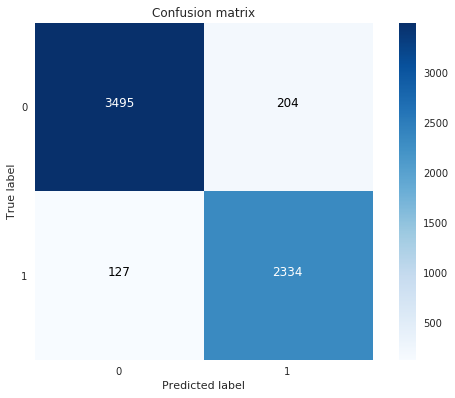

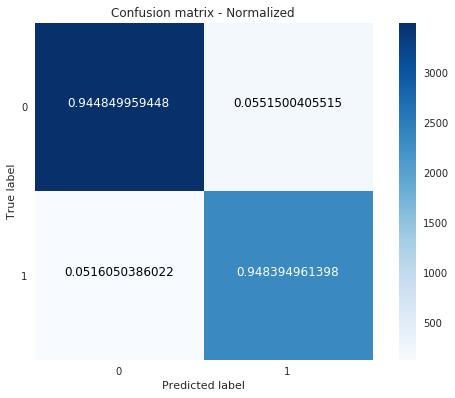

In [31]:
# Confusion matrix
lr = LogisticRegression(C = best_c)
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)

recall_score = 100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
precision_score = 100*cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])
f_score = 2 * recall_score * precision_score / (recall_score + precision_score)

print("Recall    in the testing dataset: {0:.4f} %".format(recall_score))
print("Precision in the testing dataset: {0:.4f} %".format(precision_score))
print("F Score   in the testing dataset: {0:.4f} %".format(f_score))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

# Plot Normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , normalize=True
                      , title='Confusion matrix - Normalized')
plt.show()

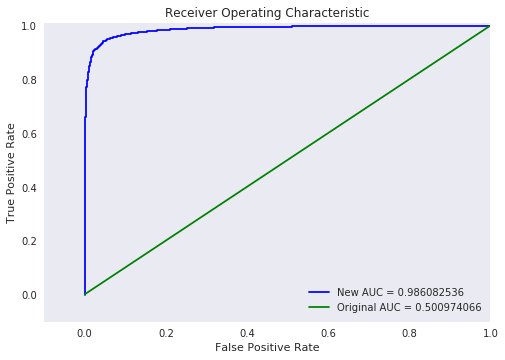

In [32]:
# ROC CURVE
lr = LogisticRegression(C = best_c)
y_pred_undersample_score = lr.fit(X_train_undersample,y_train_undersample.values.ravel()) \
                             .decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr,tpr)
fpr_org, tpr_org, thresholds_org = roc_curve(raw_data.isFraud,raw_data.isFlaggedFraud)
roc_auc_org = auc(fpr_org,tpr_org)
# Plot ROC
plt.title('Receiver Operating Characteristic')
# plt.plot([0,1],[0,1],'r--')
plt.plot(fpr, tpr, 'b',label='New AUC = %0.9f'% roc_auc)
plt.plot(fpr_org, tpr_org, 'g',label='Original AUC = %0.9f'% roc_auc_org)
plt.legend(loc='best')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [33]:
print('How much degree the new model is better than the original model?')
print('Lift Score: {0:.02f} %'.format(100 * roc_auc / roc_auc_org))

How much degree the new model is better than the original model?
Lift Score: 196.83 %


# Congratulations! A technically sound analytic model is built successfully!

# Question: Is this model good enough to propose to business department stakeholders for practical use?

### Answer: Probably <font color='red'>not</font>! Why?! Which piece of insight is missing? Well, stay tuned ^___^

By: 


顾 瞻 GU Zhan (Sam) [LinkedIn](https://sg.linkedin.com/in/zhan-gu-27a82823)


[SamIsITspecialist@gmail.com](SamIsITspecialist@gmail.com)


June 2017


Copyright 2017 GU Zhan (Sam) Some Rights Reserved

---